# 练习任务1: 与unet模型开展对比试验

In [1]:
from tensorflow.keras import backend as K
import os
import numpy as np
import random
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout,BatchNormalization,ZeroPadding2D,add, Flatten,Activation,AveragePooling2D,Dense
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler,CSVLogger,ReduceLROnPlateau
from tensorflow.keras.layers import Lambda
from tensorflow.keras.preprocessing.image import img_to_array,ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import h5py
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageOps, ImageFile
import time
from utils import *
# from historycal import LossHistory
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# load data

In [8]:
hdf5_path = ".\data\hyper_pca_6b_4c_288.hdf5" 
fd = h5py.File(hdf5_path)
fd.keys()
images,labels=np.asarray(fd['image']),np.asarray(fd['label'])
# images,labels=np.asarray((fd['image'])[:20000]),np.asarray((fd['label'])[:20000])
fd.close()
n_label=5
print(images.shape,labels.shape)
# plot_func(images/2500,np.expand_dims(labels,axis=3))

(288, 256, 256, 6) (288, 256, 256)


389.0 3934.0
0.0 23896.0
(201, 256, 256, 6) (87, 256, 256, 6) (201, 256, 256, 5) (87, 256, 256, 5)


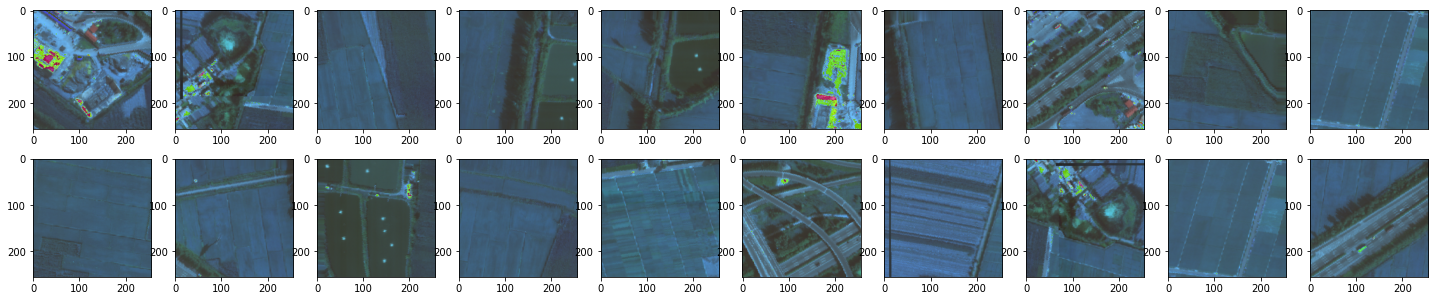

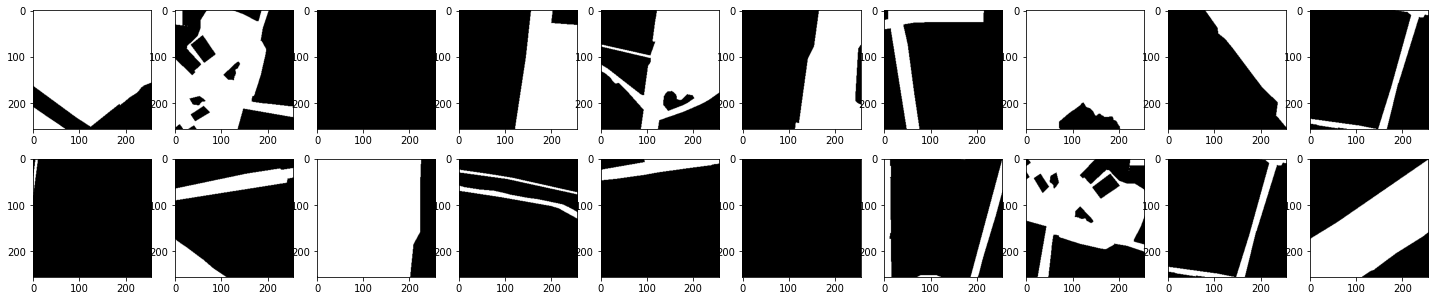

In [9]:
img,msk = get_normalized_patches(images,labels,3,10000,32000,n_label=n_label)
threshold=288
xtrain,xtest,ytrain,ytest=train_test_split(img[:threshold],msk[:threshold],test_size=0.3,shuffle=True,random_state=42)
# xval,yval=img[threshold:],msk[threshold:]
print(xtrain.shape,xtest.shape,ytrain.shape,ytest.shape)
# del img,msk,images,labels
plot_func(xtrain*4,ytrain)

# Model set

* 搭建U_net

In [10]:
class all_model(object):
    def __init__(self,loss,loss_weights,optimizer,metrics,input_height,input_width,nclass,nchannel):
        self.LOSS = loss
        self.OPTIMIZER = optimizer
        self.METRICS = metrics
        self.input_height = input_height
        self.input_width=input_width
        self.nClasses=nclass
        self.nchannel=nchannel
        self.model = None
        self.img_input=Input(shape=(self.input_height, self.input_width, self.nchannel))
        self.loss_weights=loss_weights
    
    def UNET(self):
    #     Patch_size = 256
        conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(self.img_input)
        conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
        conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
        conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

        conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

        conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
        conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

        up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
        merge6 = Concatenate(axis = -1)([conv4, up6])
        conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
        conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

        up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
        merge7 = Concatenate(axis = -1)([conv3,up7])
        conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
        conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

        up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
        merge8 = Concatenate(axis = -1)([conv2,up8])
        conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
        conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

        up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
        merge9 = Concatenate(axis = -1)([conv1,up9])
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

        conv10 = Conv2D(self.nClasses, 1, activation = 'softmax',padding = 'same')(conv9)

        self.unetmodel = Model(inputs=self.img_input, outputs=conv10)
        self.unetmodel.compile(optimizer=self.OPTIMIZER, loss=self.LOSS, metrics=self.METRICS)
        return self.unetmodel

In [11]:
loss='categorical_crossentropy'#'binary_crossentropy'
optimizer=Adam()#Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#Adam()#SGD(),Adamax(),Adadelta()R
loss_weights=''
metrics=['accuracy']
input_height=256
input_width=256
batch_size=10
epoch=30
nclass=n_label
nchannel=xtrain.shape[-1]
num_train=xtrain.shape[0]
num_val=xtest.shape[0]
ATM=all_model(loss,loss_weights,optimizer,metrics,input_height,input_width,nclass,nchannel)
nickname='U-net'

In [12]:
model=ATM.UNET()#FCN8,UNET_VGG,UNET_MINI,SQUEESE_UNET,DEEPLABV3plus,CBRRNET
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 6) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 1760        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [20]:
begin_time = time.time()          
checkpoint_DIR = "./Practice1_checkpoint\\"
if not os.path.exists(checkpoint_DIR):
    os.makedirs(checkpoint_DIR) 
model_checkpoint = ModelCheckpoint(filepath=checkpoint_DIR+nickname+"-{epoch:02d}e-val_loss{val_loss:2f}.hdf5",monitor="val_loss",save_best_only=True,mode='auto')
# histories=LossHistory()
csvlogger =CSVLogger(filename=checkpoint_DIR+nickname+'-'+str(epoch)+'-log.csv', separator=',', append=False)
# result=model.fit(xtrain, ytrain, batch_size=batch_size, epochs=epoch, verbose=1, shuffle=True,validation_data=(xtest, ytest),callbacks=[model_checkpoint,CSVLogger])
result=model.fit(xtrain, ytrain, batch_size=batch_size, epochs=epoch, verbose=1, shuffle=True,validation_data=(xtest, ytest),callbacks=[model_checkpoint,csvlogger])
end_time = time.time()
print('time lapsing {0} s \n'.format(end_time - begin_time))

Epoch 1/30
21/21 [==============================] - 5s 162ms/step - loss: 0.2382 - accuracy: 0.9224 - val_loss: 0.2916 - val_accuracy: 0.9130
Epoch 2/30
21/21 [==============================] - 3s 123ms/step - loss: 0.2383 - accuracy: 0.9223 - val_loss: 0.2434 - val_accuracy: 0.9257
Epoch 3/30
21/21 [==============================] - 3s 131ms/step - loss: 0.2483 - accuracy: 0.9237 - val_loss: 0.2981 - val_accuracy: 0.9109
Epoch 4/30
21/21 [==============================] - 3s 132ms/step - loss: 0.2690 - accuracy: 0.9167 - val_loss: 0.2555 - val_accuracy: 0.9219
Epoch 5/30
21/21 [==============================] - 3s 124ms/step - loss: 0.2501 - accuracy: 0.9121 - val_loss: 0.3108 - val_accuracy: 0.9025
Epoch 6/30
21/21 [==============================] - 3s 130ms/step - loss: 0.2634 - accuracy: 0.9126 - val_loss: 0.2850 - val_accuracy: 0.9145
Epoch 7/30
21/21 [==============================] - 3s 122ms/step - loss: 0.2798 - accuracy: 0.9092 - val_loss: 0.2761 - val_accuracy: 0.9172
Epoch 

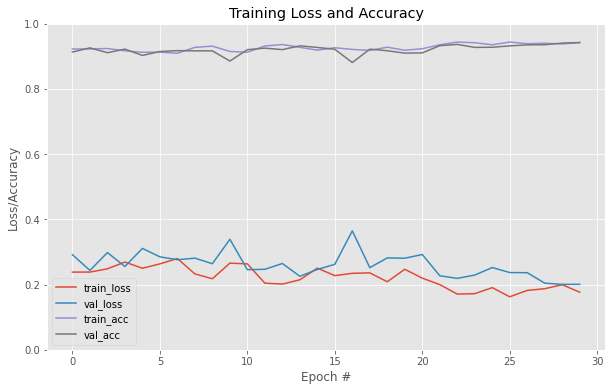

In [21]:
def plot_fig(H,outdir):
    N=len(result.history['loss'])
    plt.style.use("ggplot")
    plt.figure(figsize=(10,6))
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.ylim(0,1)

    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(outdir)
plot_fig(result,nickname+"_Loss_Acc_epoch.png")

# Prediction

In [22]:
inputdata='.\data\hyper_pca_6b_5c.tif'
img_file, img_bands, img_height, img_width, img_arr, geomatrix, projection = Load_image_by_Gdal(inputdata)
newimg=img_arr.transpose(( 1, 2,0))
newimg=np.expand_dims(newimg,axis=0)
normdata=data_split(newimg[:,:,:,:-1],3,10000,32000)
testlabel=newimg[:,:,:,-1]
PREDICTION_DIR = "./Practice1_prediction\\"+nickname+'\\'
if not os.path.exists(PREDICTION_DIR):
    os.makedirs(PREDICTION_DIR)

print("[INFO] finish loading!")
begin_time = time.time()   
normdata.reshape((normdata.shape[1:]))
model=load_model('./checkpoint\\U-net-28e-val_loss0.260654.hdf5') # 选一个精度好的轮次
outfile=PREDICTION_DIR+nickname+'_'+str(n_label)+'_pred.tif'
msk_result,mask_arr=predict(model,normdata.reshape(normdata.shape[1:]),PREDICTION_DIR,nickname,0.5,n_label)
resulttif=(mask_arr.transpose(( 2,0,1)))*10000
result=np.asarray(resulttif,dtype='uint16')
Write_Tiff(result, geomatrix, projection,outfile)
argmax_out(result,geomatrix,projection,PREDICTION_DIR+nickname+'_'+str(n_label)+'_class.tif',5000)

loadtime=end_time - begin_time
print('time lapsing {0} s \n'.format(loadtime))


409.0 4700.0
0.0 30124.0
[INFO] finish loading!
all images=1680
processing.....0    of   40
processing.....10    of   40
processing.....20    of   40
processing.....30    of   40
./Practice1_prediction\U-net\U-net_5_pred.tif 5348 5034 5 2
(5, 5034, 5348) 1
./Practice1_prediction\U-net\U-net_5_class.tif 5348 5034 1 6
time lapsing -8.502938508987427 s 



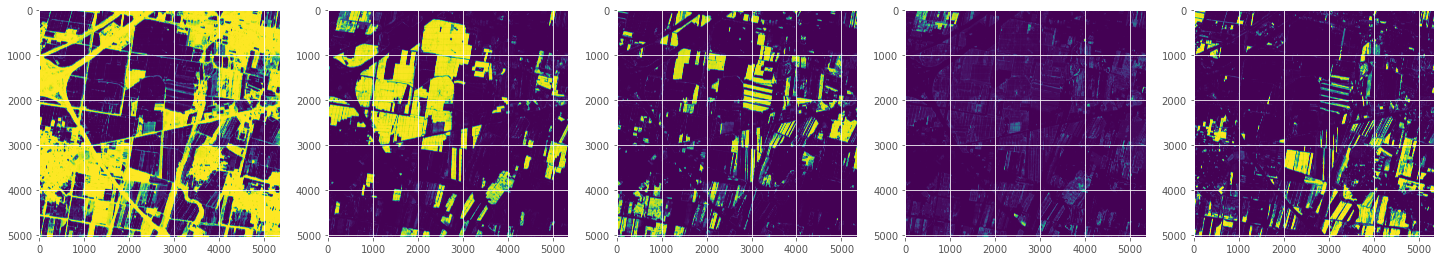

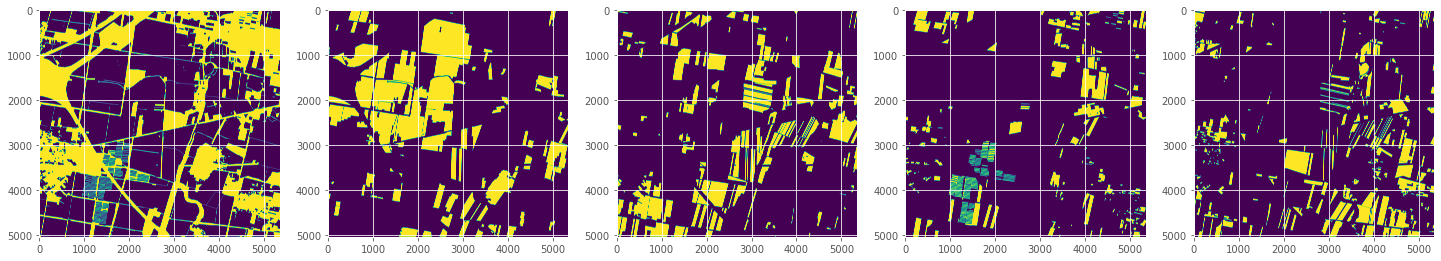

In [23]:
plot_label_func(mask_arr,(label_hot(testlabel,n_label))[0,:,:,:],n_label)